In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("../src/")

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from motion_detection import AverageDetector

In [5]:
def draw_img(img: np.ndarray, figsize: tuple = (16, 9), cmap: str = None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [81]:
def write_video(frames, name, is_colored=True):
    height, width = frames[0].shape[:2]
    video_writer = cv2.VideoWriter(
        f"{name}.mp4",
        cv2.VideoWriter_fourcc(*"mp4v"),
        30,
        (width, height),
        isColor=is_colored
    )
    
    for frame in frames:
        video_writer.write(cv2.convertScaleAbs(frame))

    video_writer.release()

# Basic (simple) task

In [6]:
background_rect = cv2.imread("../data/pictures/blue_rectangle.jpg")[..., ::-1]
foreground_rect = cv2.imread("../data/pictures/purple_rectangle.png")[..., ::-1]

In [7]:
foreground_rect = foreground_rect[30:210, 30:220]

In [8]:
background_rect.shape, foreground_rect.shape

((468, 720, 3), (180, 190, 3))

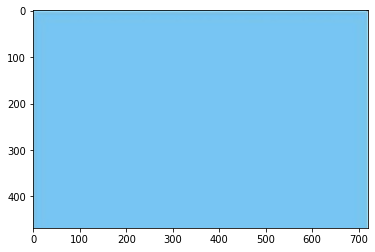

In [9]:
plt.imshow(background_rect)

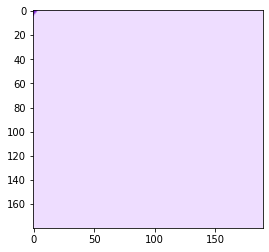

In [10]:
plt.imshow(foreground_rect)

In [11]:
foreground_rect = cv2.resize(foreground_rect, (64, 64))

In [12]:
generated_frames = [background_rect]
for i in range(300):
    x, y, width, height = 10 + i, 150, foreground_rect.shape[1], foreground_rect.shape[0]
    generated_frame = background_rect.copy()
    generated_frame[y:y+height, x:x+width] = foreground_rect
    generated_frames.append(generated_frame)

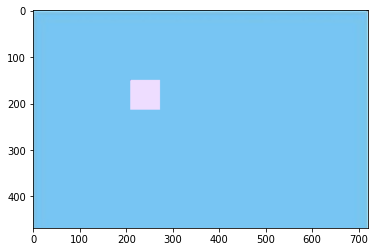

In [13]:
plt.imshow(generated_frames[200])

---

In [122]:
detector = AverageDetector(background_rect, alpha=0.99)

In [123]:
detections = []
frame_diffs = []
detector_backgrounds = []
for frame in generated_frames:
    frame_diffs.append(detector.get_frame_difference(frame, 10))
    detections.append(detector.detect(frame, diff_threshold=10, area_threshold=50))
    detector_backgrounds.append(detector.background.copy())

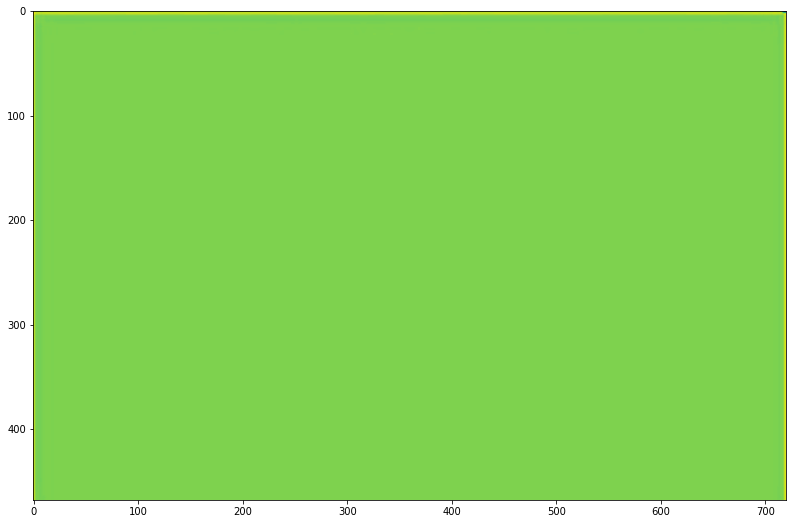

In [124]:
draw_img(detector_backgrounds[0])

In [125]:
write_video(detector_backgrounds, "average-detector-background1", is_colored=False)

In [126]:
write_video(frame_diffs, "average-detector-diffs1", is_colored=False)

In [129]:
detections_video = []
for i in range(len(detections)):
    frame_annot = generated_frames[i].copy()
    for bbox in detections[i]:
        x, y, width, height = bbox
        cv2.rectangle(frame_annot, (x, y), (x+width, y+height), color=(255, 0, 0), thickness=2)
        
    detections_video.append(frame_annot)

In [131]:
write_video(detections_video, "average-detector-detections1", is_colored=True)

---

In [132]:
def convert_to_grayscale(img: np.ndarray, ksize: tuple = (3, 3)) -> np.ndarray:
    # assuming that if shape is equal to 2 than it's already a grayscale image
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.GaussianBlur(img, ksize=ksize, sigmaX=0)

    return img

---

# Car bottom background and rectangular bomb

In [133]:
background = cv2.imread("../../data/car_bottom/car_bottom2.png")[..., ::-1]
foreground = cv2.imread("../../data/bombs/c4_csgo.webp")[..., ::-1]

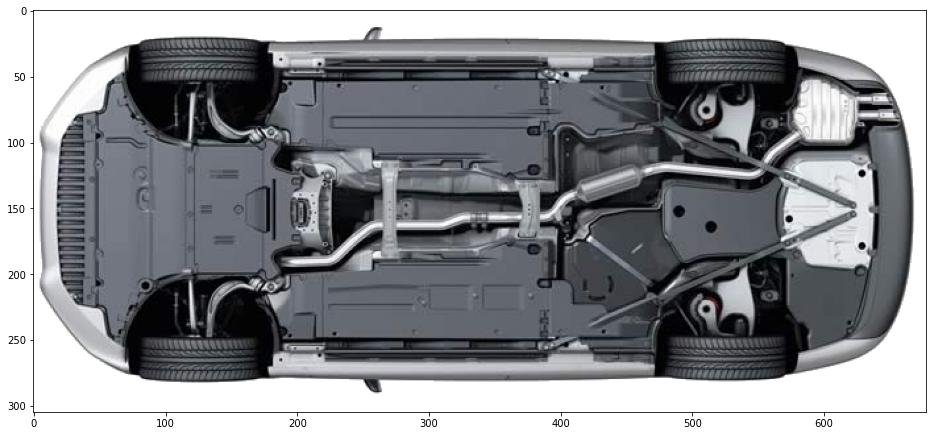

In [134]:
draw_img(background)

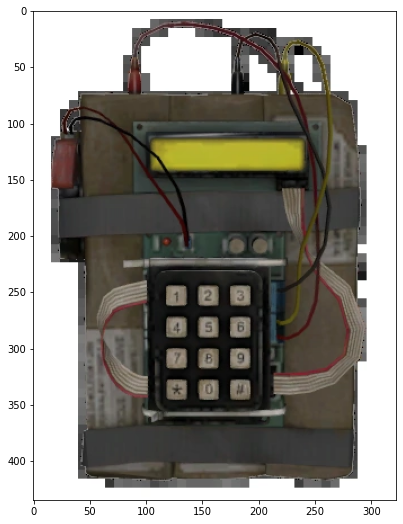

In [135]:
draw_img(foreground)

In [136]:
foreground = cv2.resize(foreground, (64, 64))

In [137]:
generated_frames = [background]
for i in range(300):
    x, y, width, height = 10 + i, 150, foreground.shape[1], foreground.shape[0]
    generated_frame = background.copy()
    generated_frame[y:y+height, x:x+width] = foreground
    generated_frames.append(generated_frame)

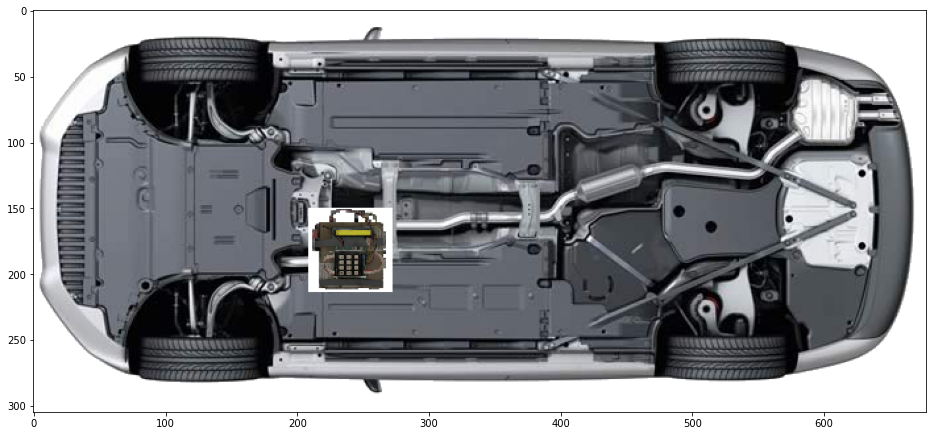

In [138]:
draw_img(generated_frames[200])

In [150]:
detector = AverageDetector(background, alpha=0.9)

In [157]:
detections = []
frame_diffs = []
detector_backgrounds = []
for frame in generated_frames:
    frame_diffs.append(detector.get_frame_difference(frame, 10))
    detections.append(detector.detect(frame, diff_threshold=10, area_threshold=10))
    detector_backgrounds.append(detector.background.copy())

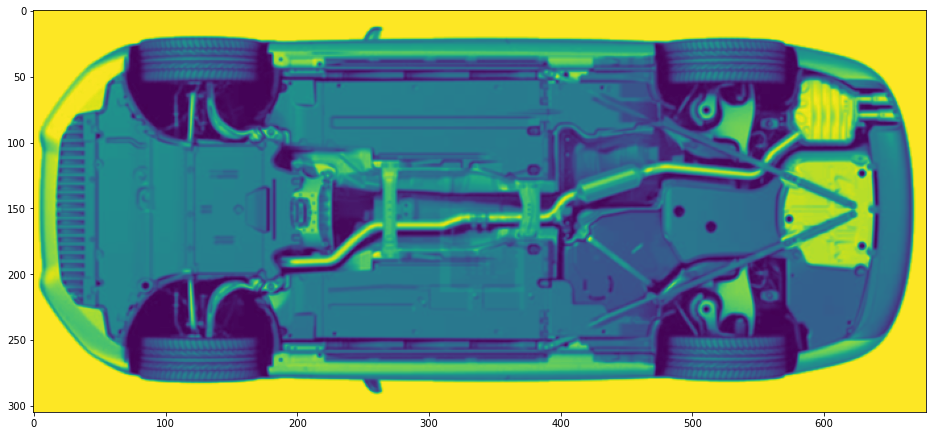

In [158]:
draw_img(detector_backgrounds[0])

In [159]:
write_video(detector_backgrounds, "average-detector-background2", is_colored=False)

In [160]:
write_video(frame_diffs, "average-detector-diffs2", is_colored=False)

In [161]:
detections_video = []
for i in range(len(detections)):
    frame_annot = generated_frames[i].copy()
    for bbox in detections[i]:
        x, y, width, height = bbox
        cv2.rectangle(frame_annot, (x, y), (x+width, y+height), color=(255, 0, 0), thickness=2)
        
    detections_video.append(frame_annot)

In [162]:
write_video(detections_video, "average-detector-detections2", is_colored=True)

---

# Car bottom background and masked (non-rectangular) bomb

In [165]:
foreground_img = Image.fromarray(foreground)
foreground_mask = Image.fromarray((foreground < 255).astype(np.uint8) * 255).convert("L")

In [166]:
generated_frames = [background]
for i in range(300):
    x, y, width, height = 10 + i, 150, foreground.shape[1], foreground.shape[0]
    generated_frame = Image.fromarray(background)
    generated_frame.paste(foreground_img, (x, y), mask=foreground_mask)
    generated_frames.append(np.asarray(generated_frame, np.uint8))

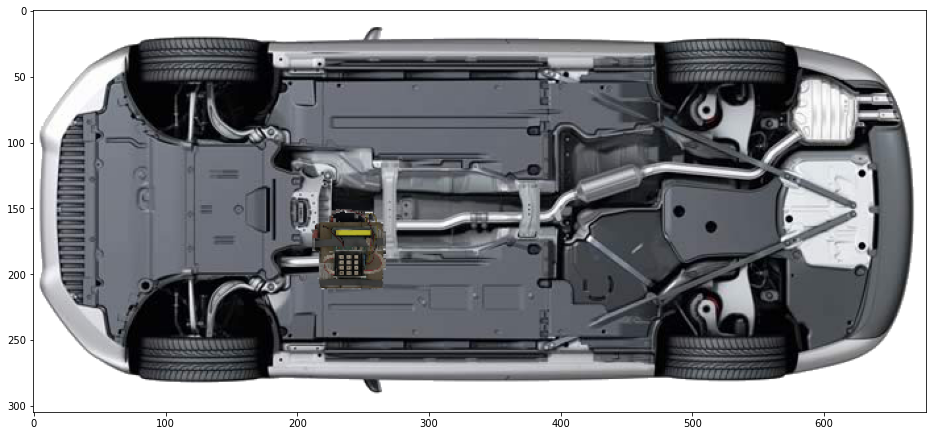

In [167]:
draw_img(generated_frames[200])

In [175]:
detector = AverageDetector(background, alpha=0.9)

In [176]:
detections = []
frame_diffs = []
detector_backgrounds = []
for frame in generated_frames:
    frame_diffs.append(detector.get_frame_difference(frame, 50))
    detections.append(detector.detect(frame, diff_threshold=50, area_threshold=10))
    detector_backgrounds.append(detector.background.copy())

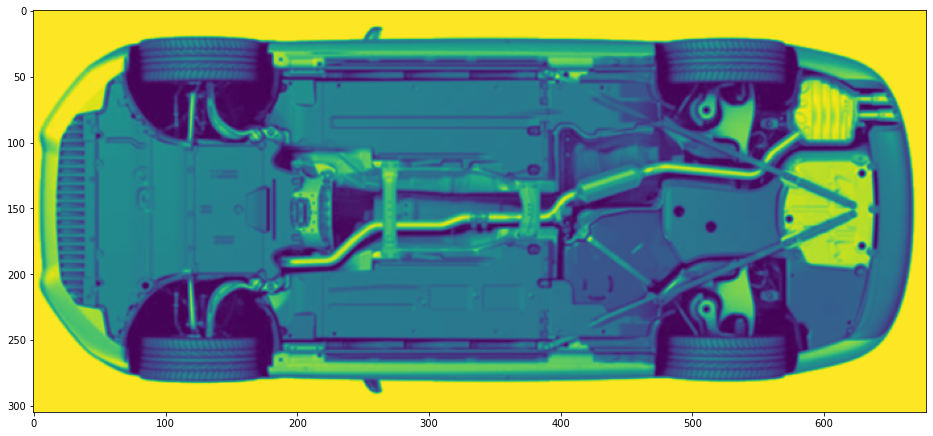

In [177]:
draw_img(detector_backgrounds[0])

In [178]:
write_video(detector_backgrounds, "average-detector-background3", is_colored=False)

In [179]:
write_video(frame_diffs, "average-detector-diffs3", is_colored=False)

In [180]:
detections_video = []
for i in range(len(detections)):
    frame_annot = generated_frames[i].copy()
    for bbox in detections[i]:
        x, y, width, height = bbox
        cv2.rectangle(frame_annot, (x, y), (x+width, y+height), color=(255, 0, 0), thickness=2)
        
    detections_video.append(frame_annot)

In [181]:
write_video(detections_video, "average-detector-detections3", is_colored=True)